In [1]:
# import required packages
from fastai2.tabular.all import *

In [2]:
# path to project directory
path = Path()

In [3]:
# read in training dataset
train_df = pd.read_csv(path/'data/train_v3.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.tail()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba
90432,Tommy_Doyle,38,3,0,Manchester City,Norwich,2.430397,0.327574,True,0,...,0,5,0.0,-2,22,24,0,2020-07-26T15:00:00Z,1920,1.0
90433,Joseph_Anang,38,1,0,West Ham United,Aston Villa,0.709989,0.553818,True,0,...,1,1,0.0,70,270,200,0,2020-07-26T15:00:00Z,1920,1.0
90434,Erik_Pieters,38,2,90,Burnley,Brighton and Hove Albion,0.370648,0.541184,True,3,...,2,1,2.0,139816,144388,4572,1,2020-07-26T15:00:00Z,1920,1.0
90435,Japhet_Tanganga,38,2,0,Tottenham Hotspur,Crystal Palace,1.604904,0.430493,False,0,...,1,1,0.0,7999,14840,6841,0,2020-07-26T15:00:00Z,1920,1.0
90436,Ravel_Morrison,38,3,0,Sheffield United,Southampton,0.348678,0.526987,False,0,...,1,3,0.0,-23,7,30,0,2020-07-26T15:00:00Z,1920,0.0


In [5]:
train_df.shape

(90437, 35)

In [6]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920']

In [7]:
# set as categories with correct order 
train_df['gw'] = train_df['gw'].astype('category')
train_df['season'] = train_df['season'].astype('category')

train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [8]:
# dependent variable needs to be float
train_df['total_points'] = train_df['total_points'].astype('float64')

In [9]:
# check data types
train_df.dtypes

player                                   object
gw                                     category
position                                  int64
minutes                                   int64
team                                     object
opponent_team                            object
relative_market_value_team              float64
relative_market_value_opponent_team     float64
was_home                                   bool
total_points                            float64
assists                                   int64
bonus                                     int64
bps                                       int64
clean_sheets                              int64
creativity                              float64
goals_conceded                            int64
goals_scored                              int64
ict_index                               float64
influence                               float64
own_goals                                 int64
penalties_missed                        

In [10]:
# find validation cut point - index for 19-20 season second half (gw 19)
valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1920')].index.min()
valid_end = train_df.index.max()

In [44]:
# set validation dataset based on indexes
train_idx = range(valid_start)
valid_idx = range(valid_start, valid_end)

splits = (list(train_idx), list(valid_idx))
valid_idx

range(77810, 90436)

In [12]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']

In [13]:
# set dependent variable
dep_var = 'total_points'

In [14]:
train_df[cat_vars].nunique()

player           1306
gw                 38
position            4
team               29
opponent_team      29
was_home            2
season              4
dtype: int64

In [15]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]
to_nn = TabularPandas(train_df, procs, cat_vars, cont_vars,
                      splits=splits, y_names=dep_var)

In [39]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [22]:
dls.show_batch()

,player,gw,position,team,opponent_team,was_home,season,minutes,relative_market_value_team,relative_market_value_opponent_team,total_points
0,Andrew_Surman,27,3,Bournemouth,Wolverhampton Wanderers,True,1819,2.833622e-08,0.418108,0.388177,0.0
1,Dejan_Lovren,11,2,Liverpool,West Ham United,False,1718,3.000001e+00,1.619155,0.866330,1.0
2,Bamidele_Alli,7,3,Tottenham Hotspur,Huddersfield Town,False,1718,9.000000e+01,1.751141,0.210654,2.0
3,Jesse_Lingard,32,3,Manchester United,Swansea City,True,1718,7.500000e+01,2.110135,0.560457,6.0
4,Victor_Lindelöf,6,2,Manchester United,Southampton,False,1718,2.833622e-08,2.110135,0.809578,0.0
5,Michael_Keane,22,2,Everton,Manchester United,True,1718,9.000000e+01,1.134226,2.110135,1.0
6,Jeff_Hendrick,33,3,Burnley,Watford,False,1718,8.999999e+00,0.316798,0.547242,1.0
7,Ethan_Ampadu,1,3,Chelsea,Huddersfield Town,False,1819,2.833622e-08,2.540586,0.273778,0.0
8,Francis_Coquelin,16,3,Arsenal,Everton,False,1617,8.700000e+01,1.944129,1.057509,5.0
9,Jack_Stephens,37,2,Southampton,Swansea City,False,1718,9.000000e+01,0.809578,0.560457,6.0


In [18]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = (-1, max_y)

In [54]:
learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
                        n_out=1, loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0012022644514217973)

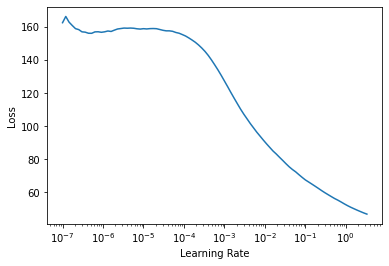

In [48]:
learn.lr_find()

In [55]:
learn.fit_one_cycle(5, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,4.191478,3.762616,1.939746,00:15
1,3.652228,3.355534,1.831812,00:15
2,3.328749,3.355761,1.831874,00:15
3,3.289095,3.272787,1.809085,00:15
4,3.067832,3.267130,1.807521,00:15


In [25]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

In [57]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

1.807521

In [27]:
preds

tensor([[-0.0926],
        [ 0.2595],
        [-0.1763],
        ...,
        [-0.2005],
        [ 5.2565],
        [-0.1782]])

In [28]:
targs

tensor([[-3.],
        [ 0.],
        [ 0.],
        ...,
        [ 0.],
        [ 3.],
        [ 0.]])